In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
import warnings
import json
import properscoring as ps
import random

In [3]:
#Display all of the rows in a dataframe
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings("ignore")
pred_len = 60

In [4]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.field_names import FieldName

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import scipy
import logging

In [15]:
filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredProduction.xlsx'
file = open(filename, "rb")
prodDF = pd.read_excel(file, engine="openpyxl")

filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredInjection.xlsx'
file = open(filename, "rb")
injectDF = pd.read_excel(file, engine="openpyxl")

In [16]:
#Group dataset by well
sc = MinMaxScaler()

well_groups = prodDF.groupby(prodDF.Well_Name)
well_names = []
wells = []
for well, data in well_groups:
    well_names.append(well)
    wells.append(data)
    
i_well_groups = injectDF.groupby(["Well_Name", "Enhanced_Recovery_Unit"])
i_wells = []
for i_well, data in i_well_groups:
    i_wells.append(data)

In [17]:
train_list = []
test_list = []
for x in wells:
    #well_name = pd.unique(x.Well_Name)[0]
    
    #If NaN gaps use reindex()
    covar_train = []
    covar_test = []
    
    for i in i_wells:
        i_well = i
        if (x.Enhanced_Recovery_Unit.iloc[0] == i.Enhanced_Recovery_Unit.iloc[0]):        #Injection: all wells
            i_well = i_well.reindex(x.Date_Production).fillna(0)
        else:
            i_well = i_well.reindex(x.Date_Production)
            i_well[:] = 0
        
        covar_train.append(i_well.Vol_Fluid_Injected[:int(x.Oil_bbls.size - pred_len)])
        covar_test.append(i_well.Vol_Fluid_Injected)
        
    covar_train = sc.fit_transform(covar_train)
    covar_test = sc.fit_transform(covar_test)
    
    prod_days = sc.fit_transform(x.Prod_Days.values.reshape(-1, 1))
    prod_days = prod_days.reshape(1, -1)[0]
    
    np.insert(covar_train, 0, prod_days[:int(x.Oil_bbls.size - pred_len)])
    np.insert(covar_test, 0, prod_days)
    
    train_list.append({
        'target': x.Oil_bbls[:int(x.Oil_bbls.size - pred_len)],
        'start': x.iloc[0].Date_Production,
        'feat_dynamic_real': covar_train
    })
    test_list.append({
        'target': x.Oil_bbls,
        'start': x.iloc[0].Date_Production,
        'feat_dynamic_real': covar_test
    })
train_ds = ListDataset(train_list, freq="1M")
test_ds = ListDataset(test_list, freq="1M")

In [18]:
def run_params(samples, cells, layers, dropout, batchSize, epoch_count, context, cellType, learn, batches_per):
    random.seed(42)
    estimator = DeepAREstimator(freq="1M", prediction_length=pred_len, 
                                trainer=Trainer(epochs=epoch_count, learning_rate = learn,
                                num_batches_per_epoch=batches_per), 
                                use_feat_dynamic_real=False,  #Tuning without Injection!!!
                                num_cells=cells, num_layers=layers, dropout_rate=dropout, batch_size=batchSize,
                                context_length = context, cell_type=cellType)
    predictor = estimator.train(training_data=train_ds)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=samples,  # number of sample paths we want for evaluation          #Tune this value???
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(train_ds))
    
    crps_list = []
    for i in range(len(tss)):
        crps = ps.crps_ensemble(tss[i][(len(tss[i]) - pred_len):][0].values, np.transpose(forecasts[i].samples)).mean()
        crps_list.append(crps)
    mean_crps = sum(crps_list)/len(crps_list)
    
    
    return mean_crps

# Constant Parameters:
    -Number of epochs: tuning: 5, testing: 100

# Parameters to Tune:   
    -num cells            num_cells
    -num layers           num_layers            
    -cell type
    -learning rate
    -Number of samples: 10 vs. 100 vs. 400
    -dropout              dropout_rate
    -batch size           batch_size
    -context length
    -batches/epoch

In [19]:
total_stages = 500

In [23]:
def gen_params():
    random.seed(40)
    
    params_list = []
    params_list.append({"epochs":5, "samples":10, "cells":40, "layers":2, "dropout":.1,
                       "batch_size":32, "context_len":None, "cell_type":"lstm", 
                       "learn_rate": .001, "batches":50})
    for x in range(total_stages):
        params_dict = {"epochs": 5, "samples":10,
                      "cells" : random.choice([20, 40, 60]),
                      "layers": random.choice([1, 2, 4]),
                      "dropout":random.choice([.1, .3, .6]),
                      "batch_size": random.choice([16, 32, 48]),
                      "context_len": random.choice([None, 12, 30]),
                      "cell_type": random.choice(['lstm', 'gru']),
                      "learn_rate": random.choice([.01, .001, .0001]),
                      "batches": random.choice([50, 100])
                     }
        params_list.append(params_dict)
    return params_list

In [24]:
def rand_search():
    
    params_list = gen_params()
    for x in range(total_stages):
        params = params_list[x]
        m_crps = run_params(epoch_count = params['epochs'],
                            samples = params['samples'], 
                            cells = params['cells'], 
                            layers = params['layers'], 
                            dropout = params['dropout'], 
                            batchSize = params['batch_size'],
                            context = params['context_len'],
                            cellType = params['cell_type'],
                            learn = params['learn_rate'],
                            batches_per = params['batches'])
        logging.warning("Completed Stage: " + str(x + 1) + "/" + str(total_stages))                              
        params["m_crps"] = m_crps
    
    resultDF = pd.DataFrame(params_list)
    return resultDF

In [25]:
#df = grid_search()
df = rand_search()
df

100%|████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s, epoch=3/5, avg_epoch_loss=6.26]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 321.88it/s]


100%|██████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.19it/s, epoch=3/5, avg_epoch_loss=6.98]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 316.30it/s]


100%|████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s, epoch=3/5, avg_epoch_loss=6.28]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 323.15it/s]


100%|██████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.84it/s, epoch=3/5, avg_epoch_loss=6.35]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 324.75it/s]


100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.19it/s, epoch=3/5, avg_epoch_loss=7.35]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 225.74it/s]


100%|████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.62it/s, epoch=3/5, avg_epoch_loss=6.39]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 324.43it/s]


100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.02it/s, epoch=3/5, avg_epoch_loss=6.78]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 255.85it/s]


100%|██████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.92it/s, epoch=3/5, avg_epoch_loss=6.54]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:02<00:00, 134.70it/s]


100%|██████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.14it/s, epoch=3/5, avg_epoch_loss=6.92]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 196.88it/s]


100%|██████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.69it/s, epoch=3/5, avg_epoch_loss=6.66]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 326.04it/s]


100%|████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.47it/s, epoch=3/5, avg_epoch_loss=6.51]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 324.75it/s]


100%|████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s, epoch=3/5, avg_epoch_loss=6.34]


Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:01<00:00, 315.99it/s]


,epochs,samples,cells,layers,dropout,batch_size,context_len,cell_type,learn_rate,batches,m_crps
0,5,10,40,2,0.1,32,NaN,lstm,0.0010,50,159.605457
1,5,10,40,4,0.6,16,NaN,gru,0.0001,50,186.426963
2,5,10,20,2,0.3,48,12.0,lstm,0.0001,50,172.225507
3,5,10,20,4,0.1,48,30.0,gru,0.0100,50,288.571195
4,5,10,60,2,0.1,32,12.0,lstm,0.0001,50,171.487318
5,5,10,40,1,0.3,48,12.0,lstm,0.0001,50,186.723116
6,5,10,40,1,0.6,32,30.0,gru,0.0010,50,198.252949
7,5,10,60,1,0.3,32,30.0,lstm,0.0100,50,177.742252
8,5,10,60,4,0.1,16,12.0,gru,0.0100,50,195.894478
9,5,10,20,2,0.3,16,12.0,gru,0.0001,100,194.698876


In [26]:
arr = df.iloc[df["m_crps"].idxmin()]

DF = pd.DataFrame(arr.drop('samples'))
DF

,461
epochs,5
cells,40
layers,4
dropout,0.3
batch_size,32
context_len,NaN
cell_type,lstm
learn_rate,0.0001
batches,100
m_crps,154.75


In [27]:
df.iloc[0]

epochs               5
samples             10
cells               40
layers               2
dropout            0.1
batch_size          32
context_len        NaN
cell_type         lstm
learn_rate       0.001
batches             50
m_crps         159.605
Name: 0, dtype: object

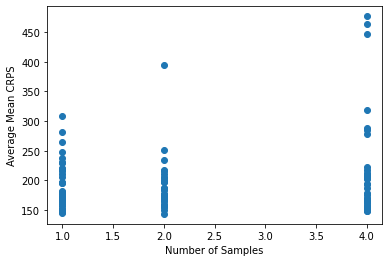

In [42]:
plt.scatter(x=df.layers, y=df.m_crps)
plt.ylabel("Average Mean CRPS")
plt.xlabel("Number of Samples")
plt.show()

# Standard Tuned Hyperparameters:
epochs	5
cells	40
layers	2
dropout	0.1
batch_size	16
context_len	NaN
cell_type	lstm
learn_rate	0.0001
batches	100
m_crps	143.221

In [1]:
        #cells = random.choice([20, 40, 60])
        #layers = random.choice([1, 2, 4])
        #dropout = random.choice([.1, .3, .6])
        #batchSize = random.choice([16, 32, 48])
        #context = random.choice([None, 12, 30])               #MUST CHANGE THIS [None, 12, 30]
        #cellType = random.choice(['lstm', 'gru'])
        #learn = random.choice([.01, .001, .0001])
        #batches_per = random.choice([50, 100]) 
Dict = {"RNN Cell count":[20, 40, 60], "RNN Layers":[1, 2, 4], "Dropout Rate":[.1, .3, .6], "Batch Size":[16, 32, 48],
        "Context Length":[0, 12, 30],
        "Cell Type":['LSTM', 'GRU', ''], "Learning Rate":[.01, .001, .0001], "Batches per Epoch":[50, 100, '']}

In [48]:
dictDF = pd.DataFrame(Dict)
dictDF = dictDF.transpose()
dictDF

,0,1,2
RNN Cell count,20,40,60
RNN Layers,1,2,4
Dropout Rate,0.1,0.3,0.6
Batch Size,16,32,48
Context Length,0,12,30
Cell Type,LSTM,GRU,
Learning Rate,0.01,0.001,0.0001
Batches per Epoch,50,100,


In [13]:
Dict = {"RNN Cell count":40, "RNN Layers":2, "Dropout Rate":.1, "Batch Size":32, "Context Length":0,
       "Cell Type":'LSTM', "Learning Rate":1e-2, "Batches per Epoch":50}

In [14]:
dictDF = pd.DataFrame(Dict, index=[0])
dictDF = dictDF.transpose()
dictDF

,0
RNN Cell count,40
RNN Layers,2
Dropout Rate,0.1
Batch Size,32
Context Length,0
Cell Type,LSTM
Learning Rate,0.01
Batches per Epoch,50


In [9]:
def grid_search():
    
    epochs = 5
    total_stages = 10
    
    result_list = []
    for samples in (10, 100, 400):
        for cells in (20, 40, 60):
            for layers in (1, 2, 4):
                for dropout in (.1, .3, .6):
                    for batchSize in range(16, 32, 48):
                        for context in (None, 12, 30):
                            for cellType in ('lstm', 'gru'):
                                for learn in (.01, .001, .0001):
                                    for batches_per in (50, 100):
                                        m_crps = run_params(samples=samples, cells=cells, layers=layers,
                                                    dropout = dropout, batchSize=batchSize, epoch_count=epochs,
                                                    context=context, cellType=cellType, learn=learn,
                                                    batches_per=batches_per)
                                        log = logging.getLogger("INFO")
                                        logging.warning(" Completed stage: " + str(current_stage) + 
                                                            "/" + str(total_stages))
                                        current_stage += 1

                                        params_list = [samples, cells, layers, (dropout * .05), 
                                                       batch, epochs, m_crps]
                                        result_list.append(params_list)
    
    resultDF = pd.DataFrame(data=result_list, columns=["samples", "cells", "layers", "dropout",
                                                       "batch", "epochs", "m_crps"])
    return resultDF